# DC v2

Perform more MDAC sweeps measuring with the lockin.

In [1]:
%matplotlib inline
import local_broom

Added 'quench/' and 'quench/libraries' for easy importing.


In [2]:
# Automagically reload modules when they are edited
%load_ext autoreload
%autoreload 2

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import time
from qcodes import Station, Instrument
from scipy.signal import find_peaks
from tqdm.notebook import tqdm

from monty import Monty
from liveplot import LivePlot, LiveContourPlot
import feedback
import swiper
import MDAC
from fridge import Fridge

# Import the neighbouring files. In may/
import may.dots as dots
from september.retort import Retort

from may.custom_devices import connect_to_gb, newSiDot
from qcodes.instrument_drivers.stanford_research.SR860 import SR860

In [4]:
##%% Connect to instruments
try:
    mdac = Instrument.find_instrument("mdac")
    mdac.close()
except KeyError:
    print('Attempting to remove instrument with name mdac. Does not exist')

mdac = MDAC.MDAC('mdac', 'ASRL11::INSTR')

try:
    lockin = Instrument.find_instrument("lockin")
    lockin.close()
except KeyError:
    print("Cannot remove instrument with name lockin. Does not exist")

#scfg = Station(config_file='/Users/LD2007/Documents/Si_CMOS_james/measurements/system.yaml')

#lockin = scfg.load_instrument('sr860_top')
#psg = scfg.load_instrument('PSG')

lockin = SR860('lockin', 'TCPIP::192.168.0.108::inst0::INSTR')
#psg = E8267('psg', 'TCPIP0::192.168.0.109::inst0::INSTR')


gb_control_si = connect_to_gb(mdac)  # Create our custom MDAC mappings
si = newSiDot(mdac)
fridge = Fridge("BlueFors_LD")

Attempting to remove instrument with name mdac. Does not exist
Connected to: QNL Sydney MDAC (serial:0x32353532353551040030003E, firmware:1.8) in 4.23s
Cannot remove instrument with name lockin. Does not exist
Connected to: Stanford_Research_Systems SR860 (serial:004279, firmware:V1.51) in 0.10s
Loading GB driver and connecting
Manually Open Breakout_box_top_ch15_LCB
Manually Open Breakout_box_bot_ch09_RCB
Manually Open Breakout_box_bot_ch17_RG
Manually Open Breakout_box_top_ch17_ResB
Manually Open Breakout_box_top_ch19_P3
Manually Open Breakout_box_top_ch13_P2
Manually Open Breakout_box_top_ch04_P1
Manually Open Breakout_box_top_ch02_SETB
Manually Open Breakout_box_bot_ch04_SRB
Manually Open Breakout_box_bot_ch06_SLB
Manually Open Breakout_box_top_ch10_ST
Manually Open Breakout_box_top_ch25_bias
Using base URL https://qphys1114.research.ext.sydney.edu.au/therm_flask/BlueFors_LD


In [9]:
# Disconnect from all devices
disconnect = True
if disconnect:
    try:
        mdac = Instrument.find_instrument("mdac")
        mdac.close()
    except KeyError:
        print('Attempting to remove instrument with name mdac. Does not exist')
    try:
        lockin = Instrument.find_instrument("lockin")
        lockin.close()
    except KeyError:
        print("Cannot remove instrument with name sr860_top. Does not exist")
    try:
        psg = Instrument.find_instrument("psg")
        psg.close()
    except KeyError:
        print('Attempting to remove instrument with name mdac. Does not exist')

Attempting to remove instrument with name mdac. Does not exist
Cannot remove instrument with name sr860_top. Does not exist
Attempting to remove instrument with name mdac. Does not exist


In [6]:
experiment = {
    "desc": "Measure detuning using RF and DC methods"
}

monty = Monty("summary.stability", experiment)

[2024-09-16 11:09:23,279] INFO Loading existing experiment (ignoring given experiment parameters)
[2024-09-16 11:09:23,300] WARNING Note that no experimental data has been loaded.
[2024-09-16 11:09:23,301] INFO Next run will have id 4


In [5]:
dots.get_all_voltages(mdac)

LCB:   0.150004 V
RCB:   0.150003 V
RG:    0.0 V
ResB:  0.0 V
P3:    0.0 V
P2:    1.299998 V
P1:    1.299996 V
SETB:  1.099999 V
SRB:   0.900001 V
SLB:   0.899997 V
ST:    3.300013 V
bias:  0.0 V
VSS1P8:      0.0 V
VSS1P0:      0.0 V
VDD1P8:      1.800005 V
VDD1P0:      0.999996 V
VDD1P8_ANA:  1.8 V
BGN1P0:      0.0 V
BGN1P8:      0.0 V
BGP1P0:      0.0 V
BGP1P8:      0.0 V
RST:         1.799996 V
MOSI:        0.0 V
SCLK:        0.0 V
SS_N:        1.8 V
APBCLK:      0.0 V
VICL:        3.500004 V
VLFG:        0.0 V
VHFG:        0.0 V


In [9]:
si.SETB(0)

## Coulomb SET sweep (1D)

[2024-09-17 11:42:19,307] INFO Started new run SET_ST_sweep.11
Sweeping Si28_quantum_dot_ST from 3.2V to 3.5V in 501 points.


  0%|          | 0/501 [00:00<?, ?it/s]

[2024-09-17 11:45:48,341] INFO Run finished and took 0:03:29.033957.
[2024-09-17 11:45:48,342] INFO Saving to SET_ST_sweep.11.xz
[2024-09-17 11:45:48,352] INFO Saving to experiment.yaml


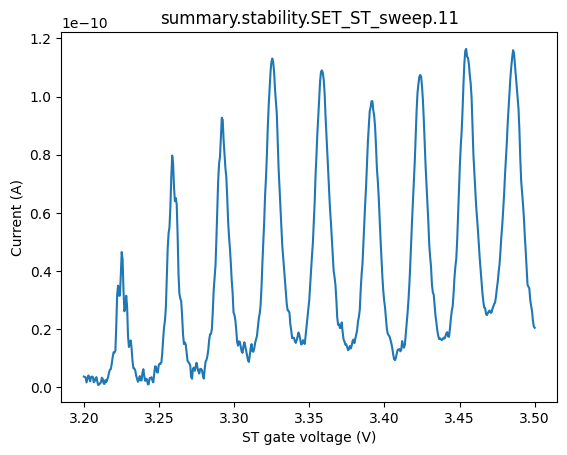

In [88]:
low = 3.2
high = 3.5
pts = 501

parameters = {
    "desc": "Quick 1D scan of the SET over ST",
    "ST":   f"range from {low}v -> {high}v, over {pts} pts",
    "SLB":  f"Fixed at {si.SLB()}V",
    "SRB":  f"Fixed at {si.SRB()}V",
    }

monty.newrun("SET ST sweep", parameters)
result = swiper.sweep1d(lockin, si.ST, low, high, pts, delay_time=0.3, monty=monty) 

monty.save(result)

## Feedback Functions

Restructure how we do feedback. Make a class that controls everything

In [11]:
retort = Retort(
    target=6e-11,
    stepsize=5e-4
)

In [22]:
si.ST(3.6)

In [23]:
retort.get_to_target(si, lockin)

Target = 6.0000e-11, tol = 1e-11, initial ST = 3.600002
ST = 3.6041e+00, lockin = 5.0866e-11, delta = 9.1131e-12
Final ST = 3.604138


In [33]:
retort.move_with_feedback(si, lockin, si.SETB, end=0.00, dx=0.001)

Target = 6.0000e-11, tol = 1e-11, initial ST = 3.499999
SETB = 0.0000e+00, ST = 3.5011e+00, lockin = 4.5447e-11, delta = 1.4648e-11
Final ST = 3.502907


In [32]:
si.SETB()

0.009997

In [31]:
np.arange(10, 5-1, -1)

array([10,  9,  8,  7,  6,  5])

## Sweep Antidetuning (2D)

In [59]:
def sweep_anti_detuning_vs_setb(p_points, setb_points):
    """Measure electrons entering and exiting the double dot. Note the asymmetry when loading/unload the dots. Find a region of SETB where it is similar."""
    p_low, p_high, p_pts = p_points
    setb_low, setb_high, setb_pts = setb_points
    parameters = {
        "desc": "Sweep anti detuning axis (P1 + P2) (feedback)",
        "lockin_amplitude": f"Set to {lockin.amplitude()} V (with divider)",
        "ST":   f"Fixed at {si.ST()}V (target of {retort.target} on lockin, stepsize = {retort.stepsize})",
        "SLB":  f"Fixed at {si.SLB()}V",
        "SRB":  f"Fixed at {si.SRB()}V",
        "J1": f"Fixed at {gb_control_si.VICL()}V",
        "P1": f"Ranged from {p_low}V -> {p_high}V in {p_pts} points",
        "P2": f"Ranged from {p_low}V -> {p_high}V in {p_pts} points",
        "SETB": f"Ranged from {setb_low} -> {setb_high} in {setb_pts} points",
        "temp": f"Mixing chamber {fridge.temp()} K",
        }
    
    monty.newrun("anti detuning loading", parameters)
    
    # gate voltage
    p_range = np.linspace(p_low, p_high, p_pts)
    setb_range = np.linspace(setb_low, setb_high, setb_pts)
    
    X = np.zeros((setb_pts, p_pts))
    Y = np.zeros((setb_pts, p_pts))
    R = np.zeros((setb_pts, p_pts))
    P = np.zeros((setb_pts, p_pts))
    ST_drift = np.zeros((setb_pts, p_pts))
    
    I = np.arange(p_pts)  # indices for datapoints
    
    with tqdm(total=setb_pts*p_pts) as pbar, LiveContourPlot(p_range, setb_range, xlabel="Antidetuning (V)", ylabel="SETB (V)") as lplot:
        for (j, setb) in enumerate(setb_range):
            
            # Set the new barrier gate
            retort.move_with_feedback(si, lockin, si.SETB, end=setb, dx=0.001, progress=False)
            #si.SETB(setb)
            
            time.sleep(1.0)  # ALlow any transitions to occur now
            
            for i in I:
                p = p_range[i]
                si.P1(p)
                si.P2(p)
                time.sleep(0.3)
                
                X[j, i] = lockin.X()
                Y[j, i] = lockin.Y()
                R[j, i] = lockin.R()
                P[j, i] = lockin.P()
                ST_drift[j, i] = si.ST()
                
                pbar.update(1)
                lplot.update(R)
                
                retort.feedback(si, lockin)
                
            monty.snapshot({"X": X, "Y": Y, "R": R, "P": P, "ST_drift": ST_drift})
            I = I[::-1]  # flip the next direction
            
    monty.save({"X": X, "Y": Y, "R": R, "P": P, "ST": ST_drift})
    
    swiper.plotsweep2d(setb_range, p_range, R, "SETB", "Antidetuning", monty)  # note wont separate directions
    swiper.plotsweep2d(setb_range[::2], p_range, R[::2, :], "SETB", "Antidetuning", extra_title=".forward", monty=monty)
    swiper.plotsweep2d(setb_range[1::2], p_range, R[1::2, :], "SETB", "Antidetuning", extra_title=".backward", monty=monty)

    return {"X": X, "Y": Y, "R": R, "P": P, "ST": ST_drift}
    

In [87]:
print(f"ST = {si.ST()}\nSLB = {si.SLB()}\nSRB = {si.SRB()}")
print(f"P1 = {si.P1()}\nP2 = {si.P2()}\nSETB = {si.SETB()}")

ST = 3.385427
SLB = 0.899997
SRB = 0.900001
P1 = 1.574004
P2 = 1.574005
SETB = 0.284383


In [39]:
# Unload any electrons
si.P1(1.0)
si.P2(1.0)
time.sleep(5)

In [72]:
si.ST(3.366515)

In [67]:
retort.get_to_target(si, lockin, progress=True)

ST = 3.5013e+00, lockin = 6.6413e-11, delta = 6.3168e-12


In [68]:
0.2/51

0.00392156862745098

In [74]:
p_low = 1.3
p_high = 1.6
p_pts = 301

setb_low = 0.4
setb_high = 0.2
setb_pts = 151

# Setup gates correctly
retort.move_with_feedback(si, lockin, si.P1, end=p_low)
retort.move_with_feedback(si, lockin, si.P2, end=p_low)
retort.move_with_feedback(si, lockin, si.SETB, end=setb_low)
time.sleep(5)

# Get to SET target
retort.get_to_target(si, lockin)
time.sleep(1)

result = sweep_anti_detuning_vs_setb((p_low, p_high, p_pts), (setb_low, setb_high, setb_pts))

Target = 6.0000e-11, tol = 1e-11, initial ST = 3.366515
ST = 3.3547e+00, lockin = 6.6846e-11, delta = 6.8315e-12elta = 2.3638e-11
ST = 3.3544e+00, lockin = 6.9113e-11, delta = 9.0638e-12elta = 1.0299e-11

Final ST = 3.354362
Target = 6.0000e-11, tol = 1e-11, initial ST = 3.354362
P2 = 1.3000e+00, ST = 3.3544e+00, lockin = 6.7840e-11, delta = 7.8187e-12
P2 = 1.3100e+00, ST = 3.3544e+00, lockin = 6.7341e-11, delta = 7.3944e-12

Final ST = 3.354362
Target = 6.0000e-11, tol = 1e-11, initial ST = 3.354362
ST = 3.3540e+00, lockin = 6.9274e-11, delta = 9.2248e-12 delta = 1.0689e-11
SETB = 3.9023e-01, ST = 3.3540e+00, lockin = 6.5870e-11, delta = 5.5267e-12

Final ST = 3.353998
ST = 3.3590e+00, lockin = 4.9853e-11, delta = 1.0064e-11
[2024-09-16 23:07:10,277] INFO Started new run anti_detuning_loading.5


  0%|          | 0/45451 [00:00<?, ?it/s]

Aborting feedback: correction voltage fails to meet threshold, 3.2999539643510416 < 3.3. No change to ST.
Aborting feedback: correction voltage fails to meet threshold, 3.29995404374355 < 3.3. No change to ST.
Aborting feedback: correction voltage fails to meet threshold, 3.2999514022222916 < 3.3. No change to ST.
Aborting feedback: correction voltage fails to meet threshold, 3.299945345088325 < 3.3. No change to ST.
Aborting feedback: correction voltage fails to meet threshold, 3.2999486392703834 < 3.3. No change to ST.
Aborting feedback: correction voltage fails to meet threshold, 3.2999393785069335 < 3.3. No change to ST.
Aborting feedback: correction voltage fails to meet threshold, 3.2999477352481583 < 3.3. No change to ST.
Aborting feedback: correction voltage fails to meet threshold, 3.29995552820425 < 3.3. No change to ST.
Aborting feedback: correction voltage fails to meet threshold, 3.299937232133575 < 3.3. No change to ST.
Aborting feedback: correction voltage fails to meet 

KeyboardInterrupt: 

In [76]:
# oop reload and see whats going on

result = monty.loaddata("anti_detuning_loading.5_SNAPSHOT.xz")

[2024-09-17 11:23:23,910] INFO Loading 'C:\Users\LD2007\Documents\Si_CMOS_james\data\summary/stability\anti_detuning_loading.5_SNAPSHOT.xz'
[2024-09-17 11:23:23,983] INFO Loaded data with run name anti_detuning_loading.5


In [83]:
lockin.R()

5.7667010056e-11

In [84]:
np.where(np.isnan(R[:, 0]))

(array([ 86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
         99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
        125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
        138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150],
       dtype=int64),)

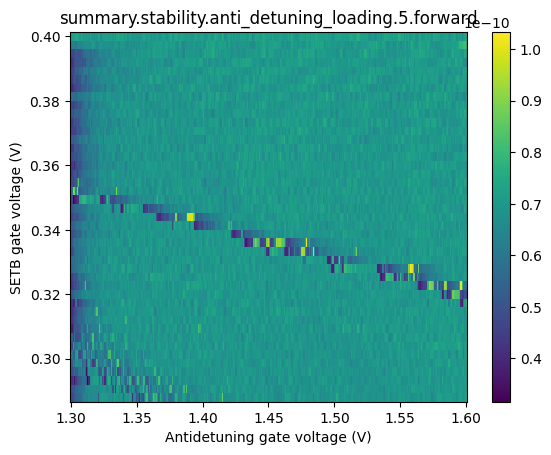

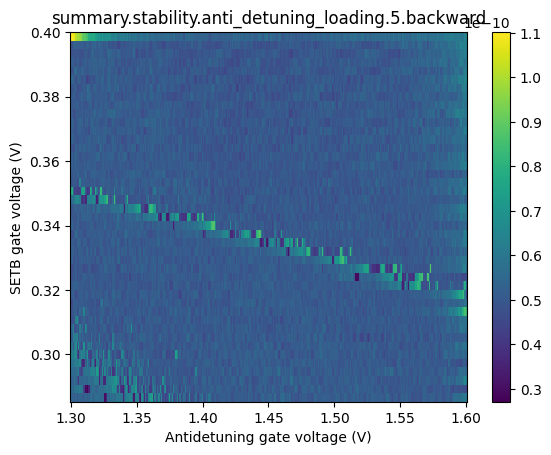

In [85]:
p_range = np.linspace(p_low, p_high, p_pts)
setb_range = np.linspace(setb_low, setb_high, setb_pts)[:86]
R = result["R"][:86, :]

swiper.plotsweep2d(setb_range[::2], p_range, R[::2, :], "SETB", "Antidetuning", extra_title=".forward", monty=monty)
swiper.plotsweep2d(setb_range[1::2], p_range, R[1::2, :], "SETB", "Antidetuning", extra_title=".backward", monty=monty)

In [78]:
monty.save(result)

[2024-09-17 11:23:34,315] INFO Run finished and took 12:16:24.037411.
[2024-09-17 11:23:34,315] INFO Saving to anti_detuning_loading.5.xz
[2024-09-17 11:23:34,635] INFO Saving to experiment.yaml
